In [1]:
!pip3 install -qq transformers

     |████████████████████████████████| 778kB 4.7MB/s 
     |████████████████████████████████| 890kB 22.9MB/s 
     |████████████████████████████████| 1.1MB 24.5MB/s 
     |████████████████████████████████| 3.0MB 44.1MB/s 


In [2]:
!pip3 install --upgrade torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.7.0+cu101)


In [3]:
import csv
import json

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

In [4]:
#Encoding:
#NonPrivate = 0
#Private = 1

d = []

In [5]:
#open csv dataset
with open('privacyDataset.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
      q = row[1] #question
      q = q.lower()
      t = row[0] #privacy type
      t = t.lower()
      #encoding
      ans = 0 
      if t == "nonprivate":
        ans = 0
      else:
        ans = 1
      my_dict = {'question': q, 'privacy': ans}
      d.append(my_dict)

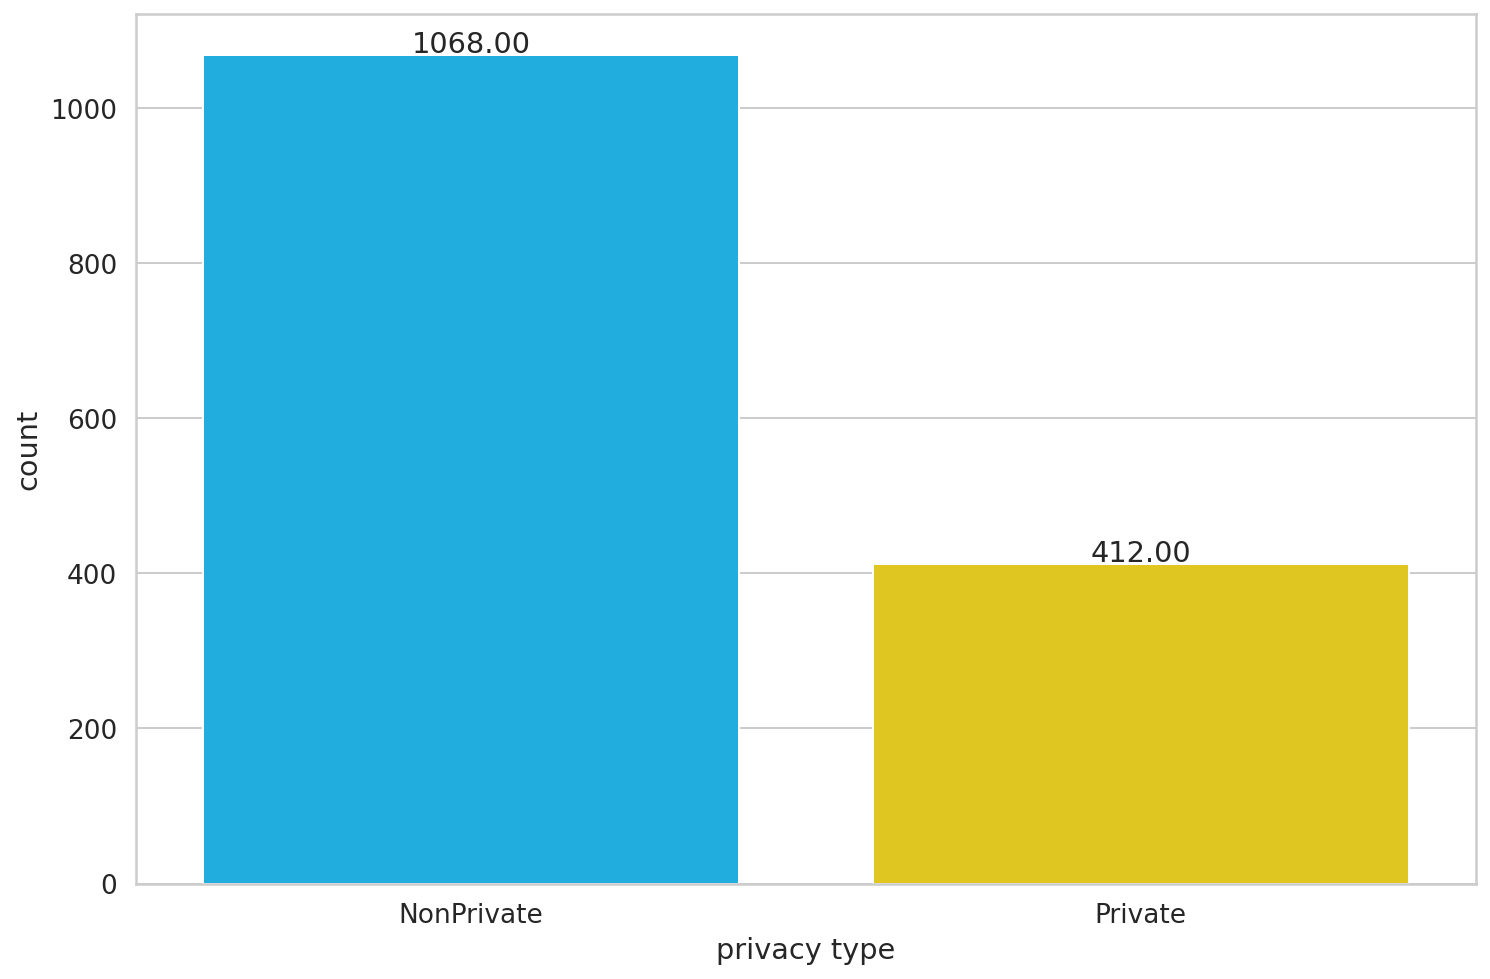

In [6]:
#convert list to dataframe
df = pd.DataFrame(data=d)
class_names = ['NonPrivate', 'Private']
ax = sns.countplot(df.privacy)
plt.xlabel('privacy type')
ax.set_xticklabels(class_names);

#showcase values on bars 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center") 

In [7]:
#loading 'cased' version of bert model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

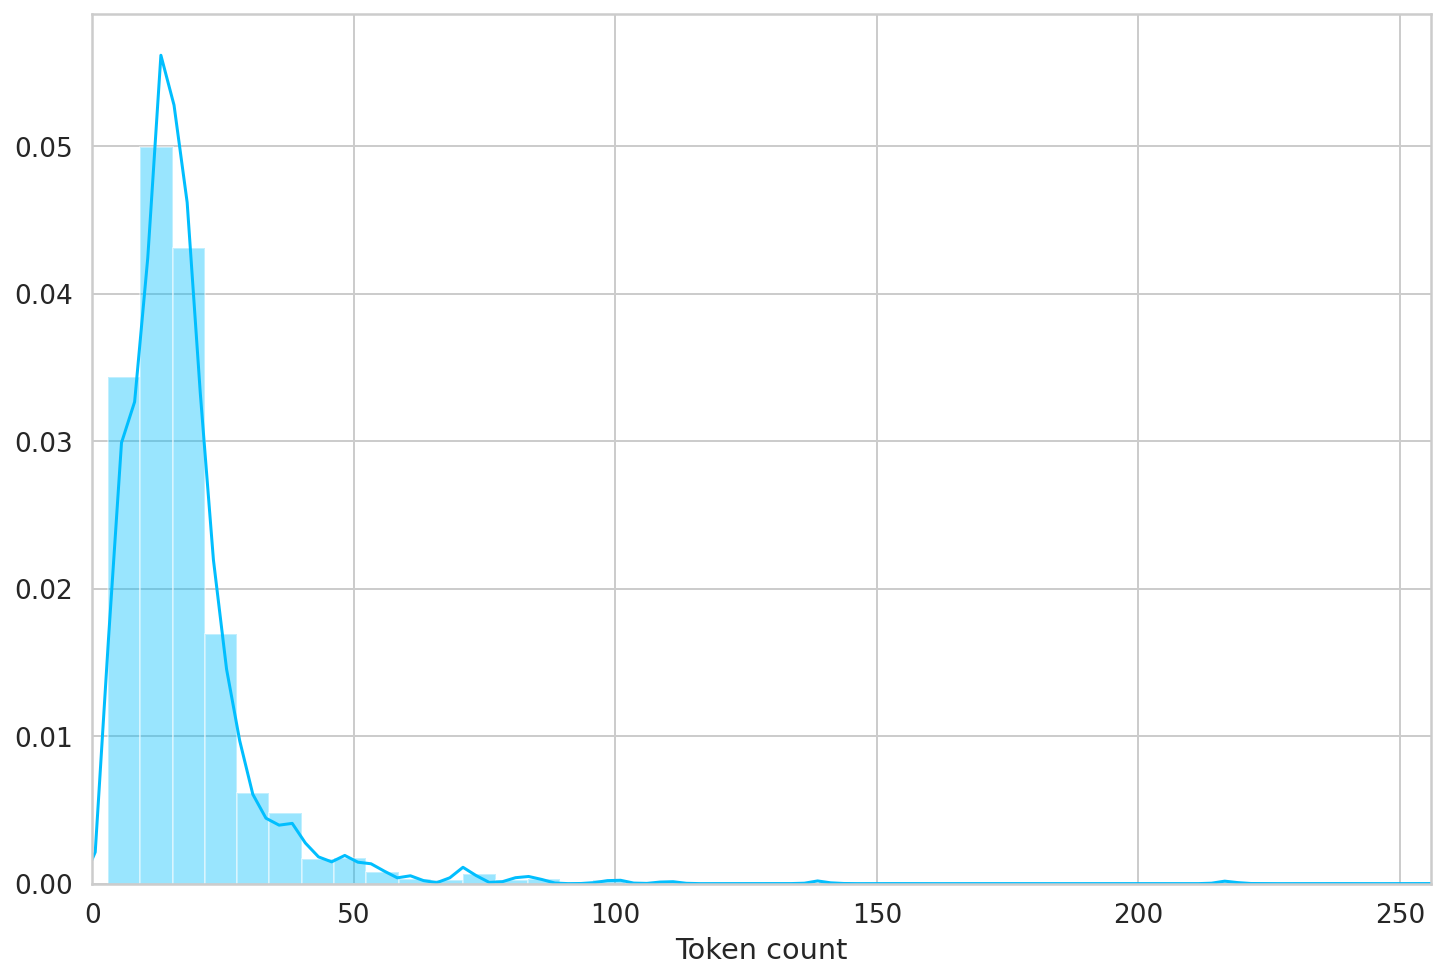

In [8]:
#determine max length of questions to add to BERT parameters
token_lens = []
for txt in df.question:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))
#graph token length distributions
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [9]:
MAX_LEN = 150

In [10]:
#create a pytorch dataset

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    #use tokenizer to encode text
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [12]:
#split dataset into training and testing
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_train.shape, df_test.shape

((1332, 2), (148, 2))

In [13]:
#download training and testing datasets 
from google.colab import files

df_train.to_csv('training_set.csv')
df_test.to_csv('testing_set.csv')
files.download('training_set.csv')
files.download('testing_set.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
#create data loaders to format data to train and test model

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.question.to_numpy(),
    targets=df.privacy.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
#download bert model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [18]:
#create a classifer using the bert model
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [19]:
#creates an instance and move to GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [20]:
#use the AdamW optimizer, provided by Hugging Face, to correct weight decay
#use a linear scheduler

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [21]:
#helpfer function to train model for one epoch
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    #encode 
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    #output from model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    
    #eval output
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    #optimize 
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
#helpfer function to evaluate data loader
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      #encode
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      #output from model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      #eval output
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
#using helper functions above, this training loops trains the model 

%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  #train single epoch
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')

  #evaluate on testing 
  test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device, 
    len(df_test)
  )
  print(f'test   loss {test_loss} accuracy {test_acc}')
  print()

  #keep track of accuracies and losses
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  #update best model 
  if test_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = test_acc

Epoch 1/10
----------
Train loss 0.3364302419857787 accuracy 0.8836336336336337
test   loss 0.3823887124657631 accuracy 0.9121621621621622

Epoch 2/10
----------
Train loss 0.1562386599613265 accuracy 0.9542042042042042
test   loss 0.31778875440359117 accuracy 0.9324324324324325

Epoch 3/10
----------
Train loss 0.08504670499435936 accuracy 0.9767267267267267
test   loss 0.20844849599525334 accuracy 0.945945945945946

Epoch 4/10
----------
Train loss 0.033796025006311195 accuracy 0.9917417417417417
test   loss 0.1736352809384698 accuracy 0.9594594594594595

Epoch 5/10
----------
Train loss 0.014976541334319683 accuracy 0.996996996996997
test   loss 0.1664574692447786 accuracy 0.9594594594594595

Epoch 6/10
----------
Train loss 0.00875041787626937 accuracy 0.9984984984984985
test   loss 0.16042363398664747 accuracy 0.9594594594594595

Epoch 7/10
----------
Train loss 0.0066701432291925555 accuracy 0.9984984984984985
test   loss 0.18962307796537062 accuracy 0.9662162162162162

Epoch 8/1

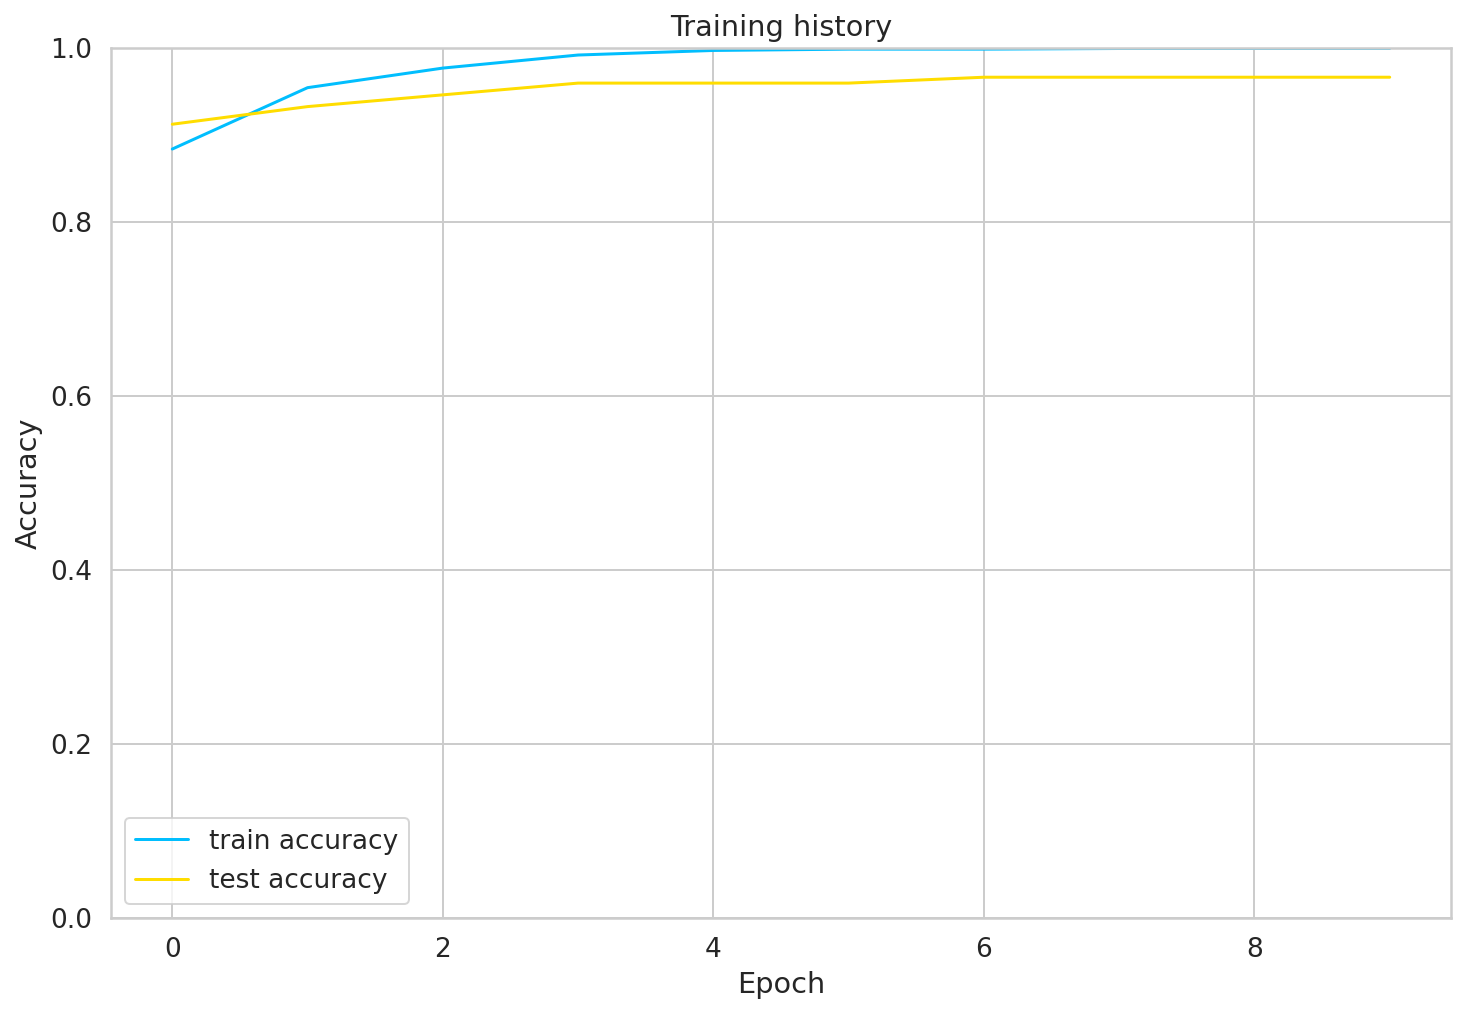

In [25]:
#plot the training and testing accuracy

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [28]:
#helper function to get predictions from the model
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      #encode
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      
      #output from model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      #eval output
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [29]:
#get prediction values of testing data
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

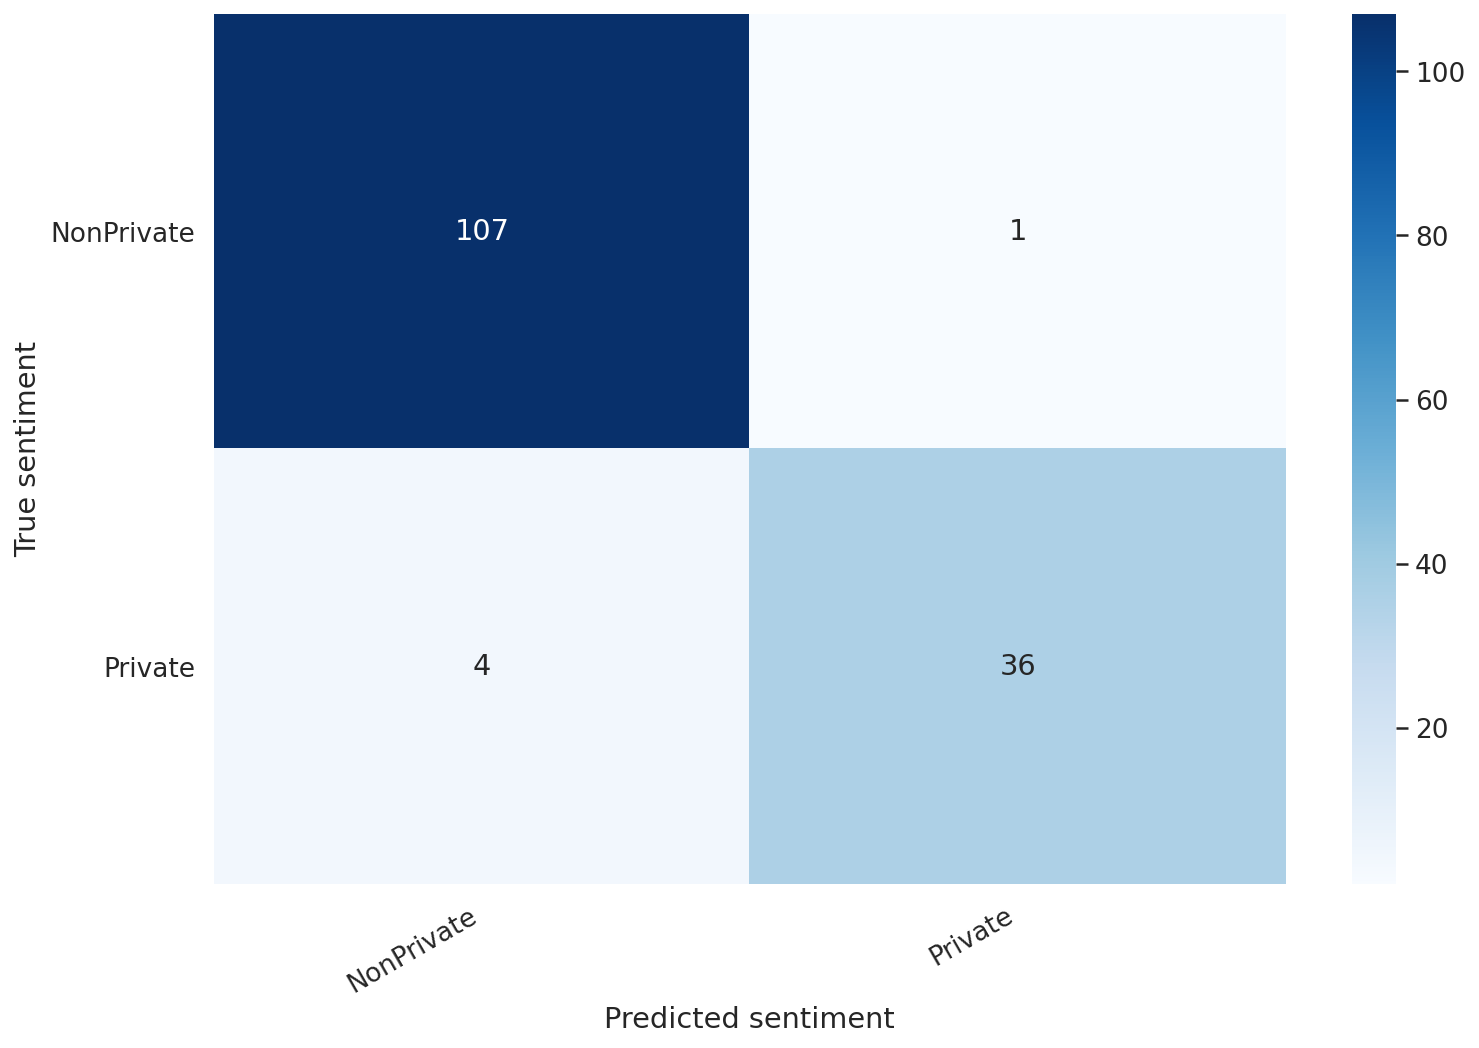

In [30]:
#helper function to show confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)